In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import random
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from models import *
from utils import *
from train import *
from bvc import *
from gen_data import *

sns.set(font_scale=1.2)
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## BNN Architectures

### Feedforward BNN

In [27]:
X_train, Y_train = load_data('./data/', 'train_feedforward.pkl')
X_test, Y_test = load_data('./data/', 'test_feedforward.pkl')
X_valid, Y_valid = load_data('./data/', 'valid_feedforward.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [28]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30,
    **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 4, final eval loss: 309.9642219543457, time elapsed: 0 h 2 m 36 s
2th repeat: best hidden unit: 256, best layers: 2, final eval loss: 308.61891174316406, time elapsed: 0 h 5 m 15 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 310.680606842041, time elapsed: 0 h 7 m 55 s
4th repeat: best hidden unit: 256, best layers: 3, final eval loss: 309.7972640991211, time elapsed: 0 h 10 m 29 s
5th repeat: best hidden unit: 256, best layers: 2, final eval loss: 311.12380599975586, time elapsed: 0 h 13 m 8 s
6th repeat: best hidden unit: 256, best layers: 2, final eval loss: 309.4200744628906, time elapsed: 0 h 15 m 47 s
7th repeat: best hidden unit: 256, best layers: 2, final eval loss: 313.64991760253906, time elapsed: 0 h 18 m 25 s
8th repeat: best hidden unit: 256, best layers: 3, final eval loss: 309.8556022644043, time elapsed: 0 h 21 m 1 s
9th repeat: best hidden unit: 256,

Best hidden unit: 256, best layers: 2


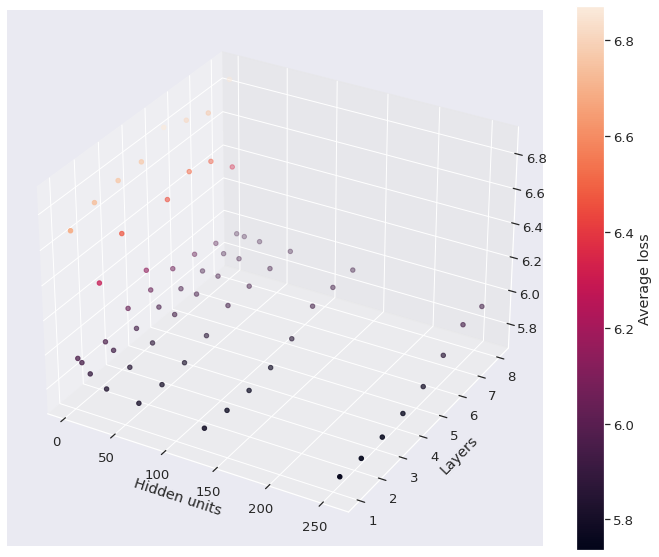

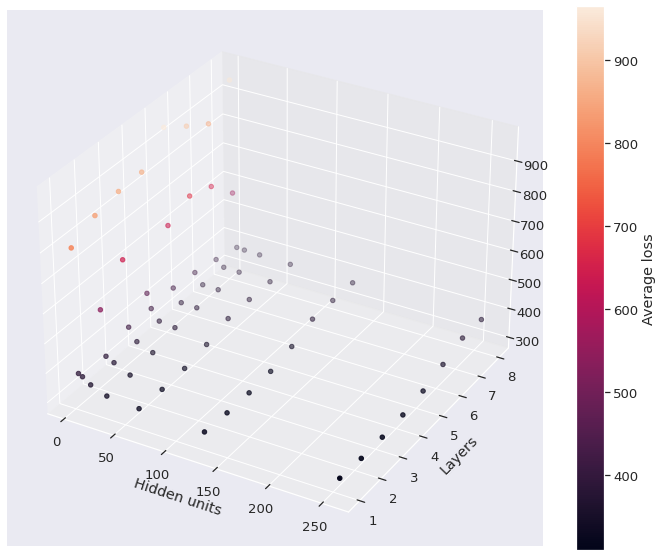

In [29]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='feedforward_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='feedforward')

####  2. Learning with best parameter

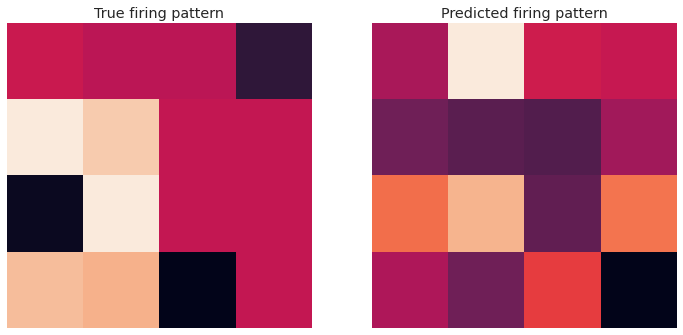

Initial eval loss: 1488.8457336425781
Epoch 1: training loss 5794.132385253906, eval loss 390.49999237060547. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 3760.5929565429688, eval loss 381.36266326904297. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 3616.9313049316406, eval loss 358.03208923339844. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 3412.7172355651855, eval loss 344.14219665527344. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 3321.6891555786133, eval loss 336.2261657714844. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 3267.3185386657715, eval loss 332.50424575805664. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 3237.8250694274902, eval loss 331.8341827392578. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 3206.9476623535156, eval loss 328.6893424987793. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 3189.7101097106934, eval loss 325.591796875. Time elapsed: 0 h 0 m 0 s.
Epoch 10: training loss 3155.679039001465, eval loss 323.1799964904785.

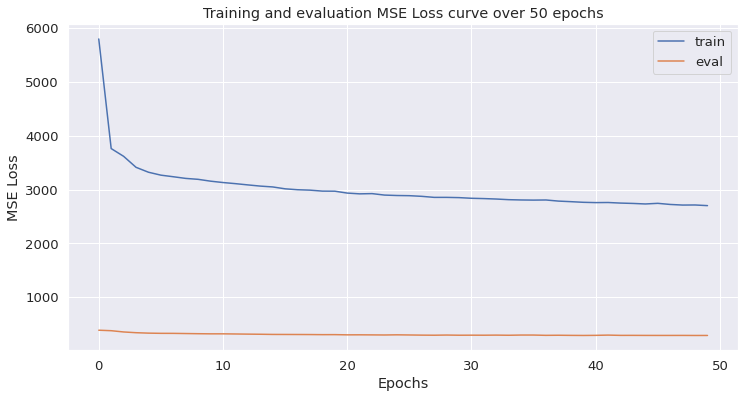

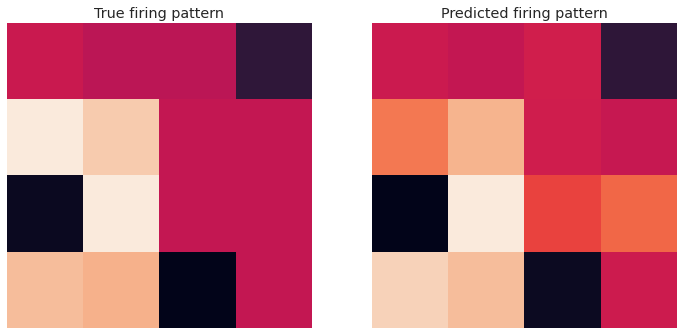

In [30]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=2, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:])) # visualise after training

#### 3. Testing against predicting the mean

In [31]:
with torch.no_grad(): 
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1), Y_test))

DNN prediction MSE error on test set:  tensor(58.6219, device='cuda:0')
Predicting mean MSE error on test set tensor(75.3590, device='cuda:0')


### Residual BNN

In [32]:
X_train, Y_train = load_data('./data/', 'train_residual.pkl')
X_test, Y_test = load_data('./data/', 'test_residual.pkl')
X_valid, Y_valid = load_data('./data/', 'valid_residual.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [33]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 2, final eval loss: 450.34690856933594, time elapsed: 0 h 2 m 37 s
2th repeat: best hidden unit: 256, best layers: 2, final eval loss: 452.19683837890625, time elapsed: 0 h 5 m 20 s
3th repeat: best hidden unit: 256, best layers: 2, final eval loss: 451.5983123779297, time elapsed: 0 h 7 m 57 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 447.8116760253906, time elapsed: 0 h 10 m 37 s
5th repeat: best hidden unit: 256, best layers: 2, final eval loss: 451.24501037597656, time elapsed: 0 h 13 m 16 s
6th repeat: best hidden unit: 256, best layers: 2, final eval loss: 452.8393859863281, time elapsed: 0 h 15 m 56 s
7th repeat: best hidden unit: 256, best layers: 2, final eval loss: 449.42240142822266, time elapsed: 0 h 18 m 35 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 448.47095489501953, time elapsed: 0 h 21 m 13 s
9th repeat: best hidden unit:

Best hidden unit: 256, best layers: 2


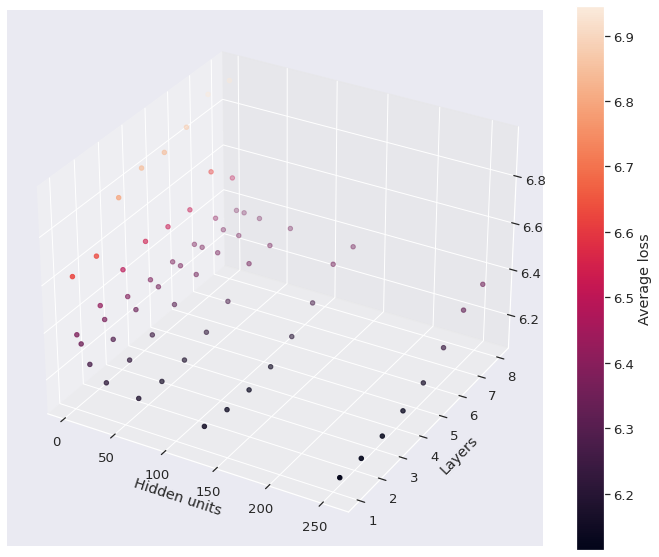

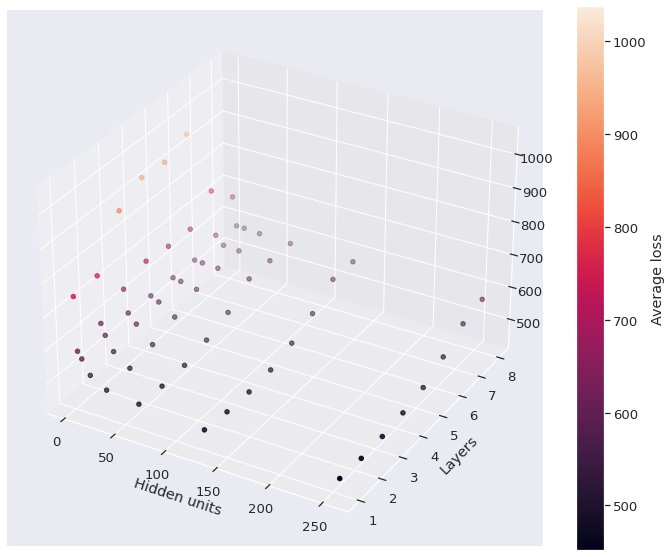

In [34]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='residual_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='residual')

#### 2. Learning with best parameter

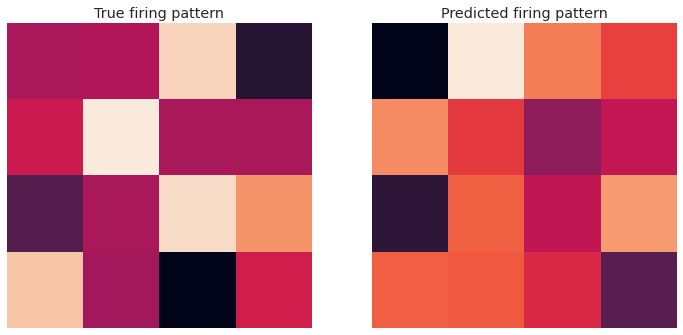

Initial eval loss: 1391.5552062988281
Epoch 1: training loss 7231.668663024902, eval loss 589.7606658935547. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 5677.071365356445, eval loss 545.5973663330078. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 5161.235153198242, eval loss 502.5375671386719. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 4890.683441162109, eval loss 487.10945892333984. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 4808.045341491699, eval loss 484.7932662963867. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 4747.414932250977, eval loss 475.61122131347656. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 4708.089576721191, eval loss 471.6726837158203. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 4661.672119140625, eval loss 468.59264373779297. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 4624.2382736206055, eval loss 467.16263580322266. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training loss 4573.977752685547, eval loss 468.86582946777344. Ti

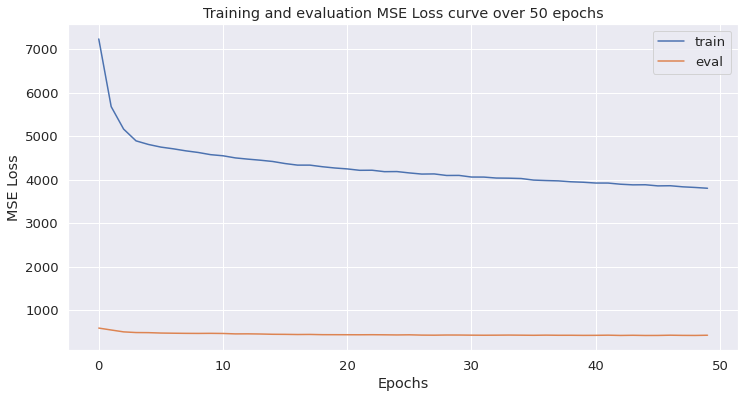

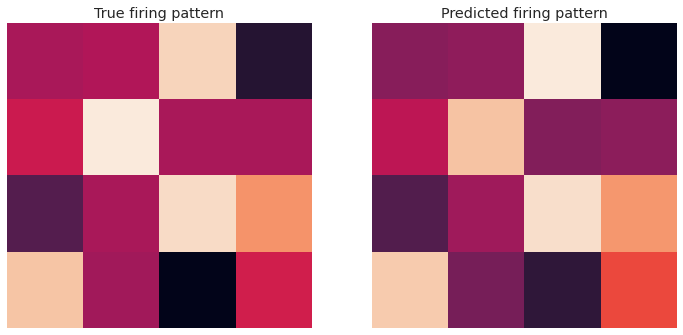

In [35]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=2, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:])) # visualise after training

#### 3. Testing against predicting the mean

In [36]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1), Y_test))

DNN prediction MSE error on test set:  tensor(85.0811, device='cuda:0')
Predicting mean MSE error on test set tensor(116.5831, device='cuda:0')


### Recurrent BNN

In [37]:
X_train, Y_train = load_data('./data/', 'train_recurrent.pkl')
X_test, Y_test = load_data('./data/', 'test_recurrent.pkl')
X_valid, Y_valid = load_data('./data/', 'valid_recurrent.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 1. Using MLP

##### a) Parameter search

In [9]:
_X_train = X_train.view(-1, 16)
_Y_train = Y_train.view(-1, 16)
_X_test = X_test.view(-1, 16)
_Y_test = Y_test.view(-1, 16)

_train_dataset = BNN_Dataset(_X_train, _Y_train)
_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

_test_dataset = BNN_Dataset(_X_test, _Y_test)
_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 378.70289611816406, time elapsed: 0 h 3 m 14 s
2th repeat: best hidden unit: 256, best layers: 4, final eval loss: 374.58546447753906, time elapsed: 0 h 6 m 34 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 377.8993606567383, time elapsed: 0 h 9 m 56 s
4th repeat: best hidden unit: 256, best layers: 4, final eval loss: 375.43897247314453, time elapsed: 0 h 13 m 18 s
5th repeat: best hidden unit: 256, best layers: 4, final eval loss: 377.7790832519531, time elapsed: 0 h 16 m 41 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 378.3124313354492, time elapsed: 0 h 20 m 3 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 376.7869338989258, time elapsed: 0 h 23 m 28 s
8th repeat: best hidden unit: 256, best layers: 3, final eval loss: 374.38646697998047, time elapsed: 0 h 26 m 52 s
9th repeat: best hidden unit: 2

Best hidden unit: 256, best layers: 3


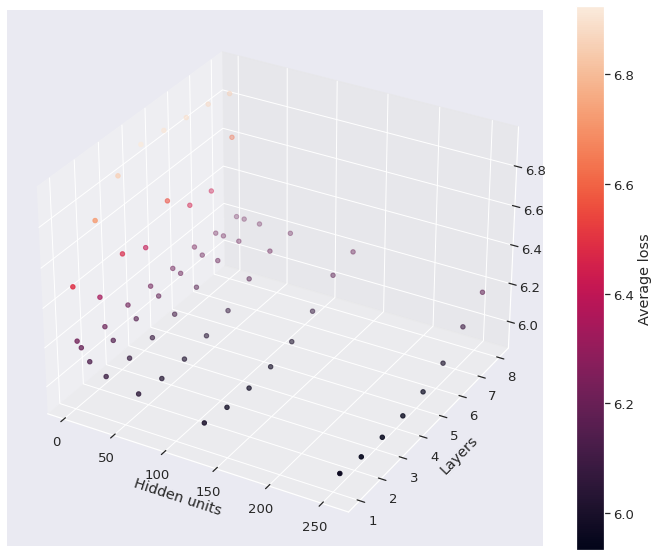

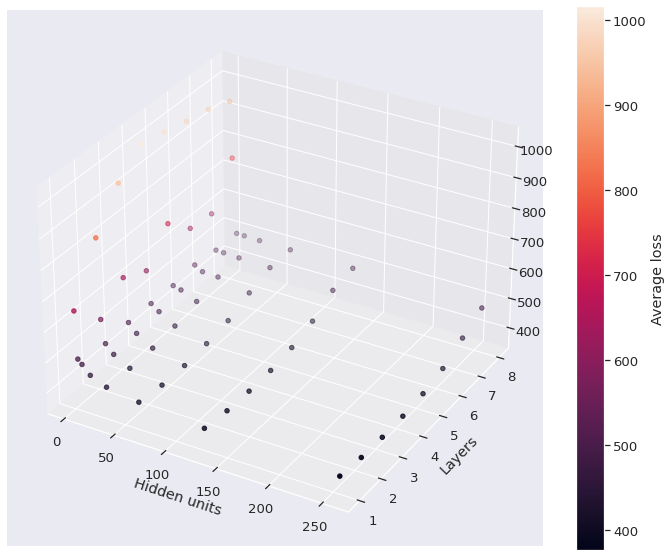

In [39]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='recurrent_mlp_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='recurrent_mlp')

##### b) Learning with best parameter

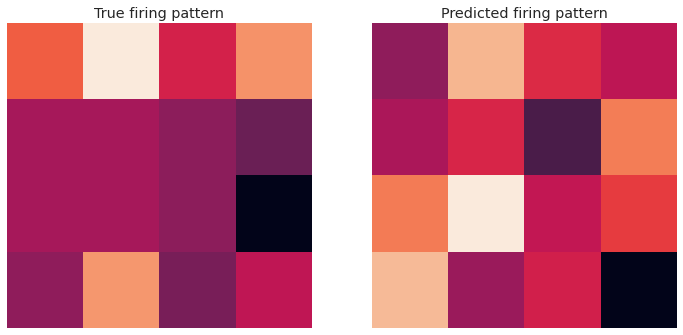

Initial eval loss: 97.13646697998047
Epoch 1: training loss 277.017902135849, eval loss 18.953993797302246. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 186.70098686218262, eval loss 18.439990043640137. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 181.18194198608398, eval loss 17.663910388946533. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 174.76826000213623, eval loss 17.33486247062683. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 172.85585403442383, eval loss 17.2236385345459. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 171.78336548805237, eval loss 17.12631630897522. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 170.82549333572388, eval loss 17.02446484565735. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 169.92324805259705, eval loss 16.96133828163147. Time elapsed: 0 h 0 m 1 s.
Epoch 9: training loss 169.25403332710266, eval loss 16.915497064590454. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training loss 168.70635962486267, eval loss 16.84104633331299

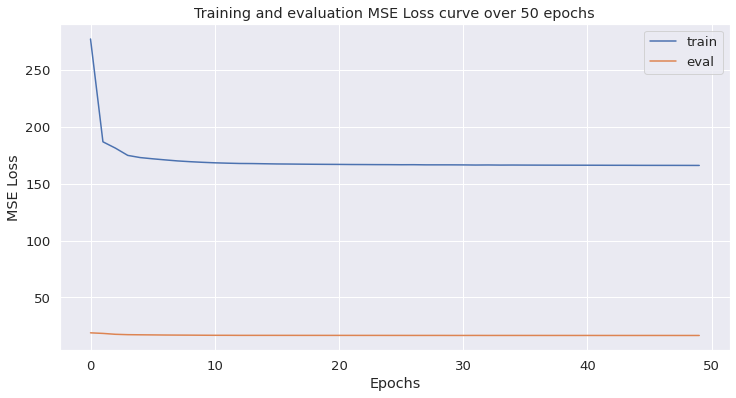

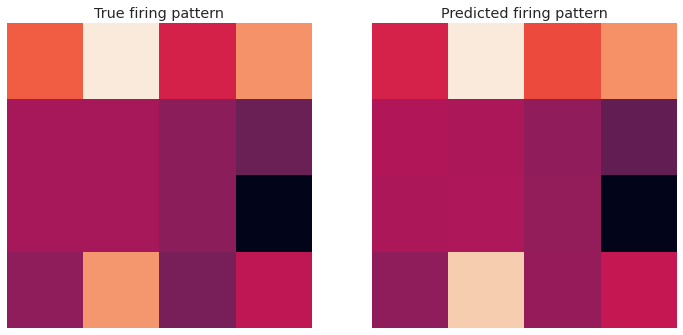

In [32]:
v_idx = np.random.randint(0, len(_Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=_train_dataloader, test_loader=_test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:])) # visualise after training

##### c) Testing against predicting the mean

In [33]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(_X_test), _Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(_Y_test, dim=0).repeat([50000,1]), _Y_test))

DNN prediction MSE error on test set:  tensor(3.3255, device='cuda:0')
Predicting mean MSE error on test set tensor(3.7158, device='cuda:0')


#### 2. Using RNN

##### a) Parameter search

In [40]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 4, final eval loss: 406.0553741455078, time elapsed: 0 h 3 m 18 s
2th repeat: best hidden unit: 256, best layers: 5, final eval loss: 406.33909606933594, time elapsed: 0 h 6 m 38 s
3th repeat: best hidden unit: 256, best layers: 8, final eval loss: 406.0494918823242, time elapsed: 0 h 9 m 58 s
4th repeat: best hidden unit: 256, best layers: 7, final eval loss: 405.69010162353516, time elapsed: 0 h 13 m 18 s
5th repeat: best hidden unit: 256, best layers: 5, final eval loss: 405.6748046875, time elapsed: 0 h 16 m 40 s
6th repeat: best hidden unit: 256, best layers: 2, final eval loss: 407.1425018310547, time elapsed: 0 h 20 m 1 s
7th repeat: best hidden unit: 256, best layers: 7, final eval loss: 405.2816848754883, time elapsed: 0 h 23 m 21 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 406.2826385498047, time elapsed: 0 h 26 m 41 s
9th repeat: best hidden unit: 256, b

Best hidden unit: 256, best layers: 2


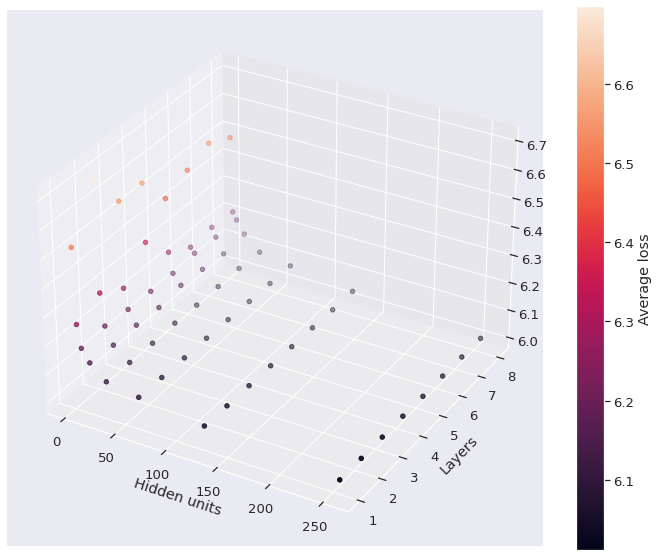

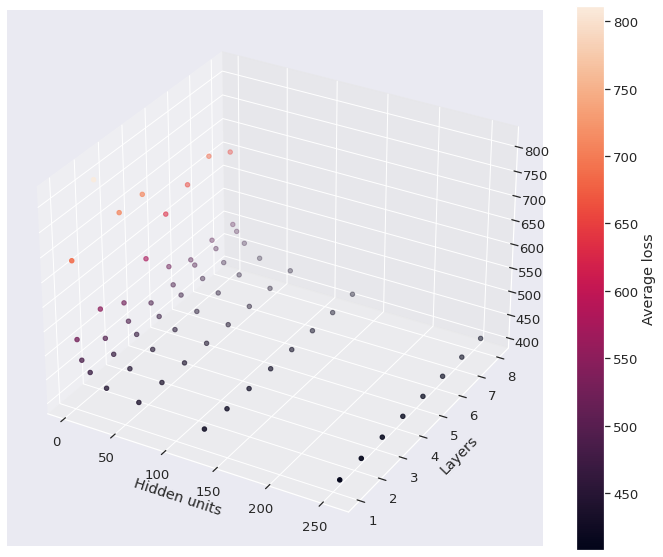

In [41]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='recurrent_lstm_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='recurrent_lstm')

##### b) Learning with best parameter

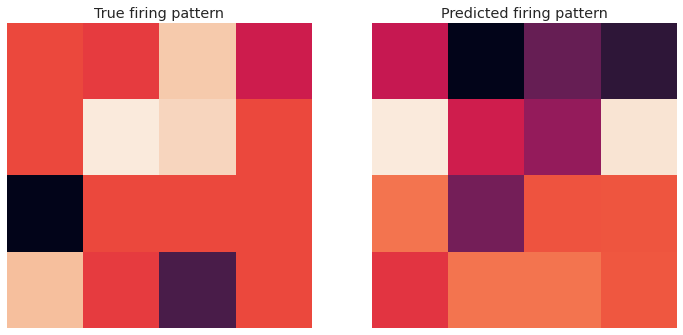

Initial eval loss: 611.4433288574219
Epoch 1: training loss 2335.012689590454, eval loss 85.93816375732422. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 811.2748336791992, eval loss 77.15928936004639. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 751.4533176422119, eval loss 71.99549961090088. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 704.1851711273193, eval loss 68.26047897338867. Time elapsed: 0 h 0 m 1 s.
Epoch 5: training loss 678.1472940444946, eval loss 66.7960376739502. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 668.4779109954834, eval loss 66.16812992095947. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 662.3526668548584, eval loss 65.52876567840576. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 655.279990196228, eval loss 64.77088928222656. Time elapsed: 0 h 0 m 2 s.
Epoch 9: training loss 647.5034198760986, eval loss 63.93972206115723. Time elapsed: 0 h 0 m 2 s.
Epoch 10: training loss 638.9517850875854, eval loss 63.076674461364746. Time elaps

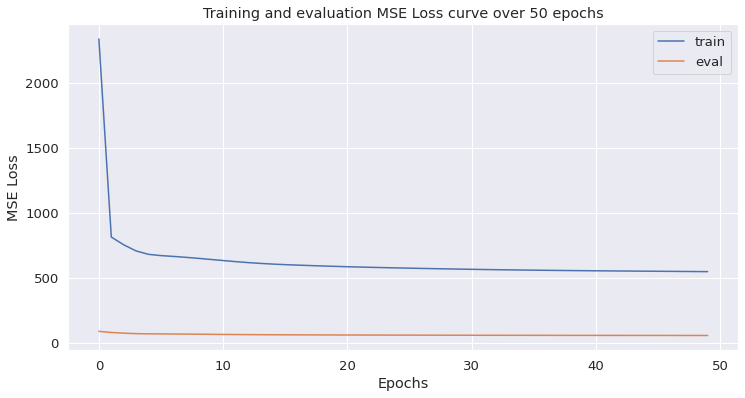

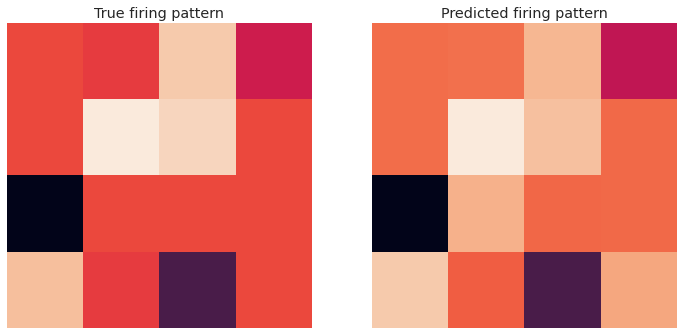

In [34]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=7, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

##### c) Testing against predicting the mean

In [35]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

DNN prediction MSE error on test set:  tensor(10.8266, device='cuda:0')
Predicting mean MSE error on test set tensor(16.4788, device='cuda:0')


### Complex BNN

In [3]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 200    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 1. Using MLP

##### a) Parameter search

In [18]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 22.18239688873291, time elapsed: 0 h 3 m 18 s
2th repeat: best hidden unit: 256, best layers: 2, final eval loss: 22.221540927886963, time elapsed: 0 h 6 m 42 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 22.21207904815674, time elapsed: 0 h 10 m 7 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 22.20817804336548, time elapsed: 0 h 13 m 29 s
5th repeat: best hidden unit: 256, best layers: 3, final eval loss: 22.200093269348145, time elapsed: 0 h 16 m 54 s
6th repeat: best hidden unit: 256, best layers: 4, final eval loss: 22.21830129623413, time elapsed: 0 h 20 m 17 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 22.206290245056152, time elapsed: 0 h 23 m 40 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 22.185306072235107, time elapsed: 0 h 27 m 5 s
9th repeat: best hidden unit: 2

Best hidden unit: 256, best layers: 3


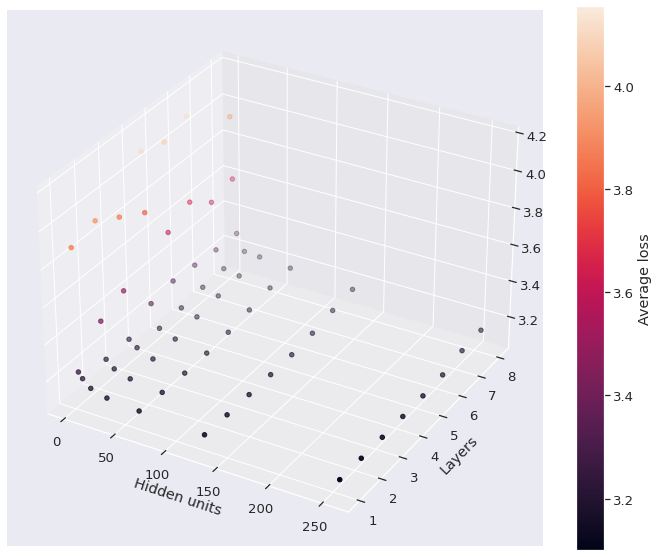

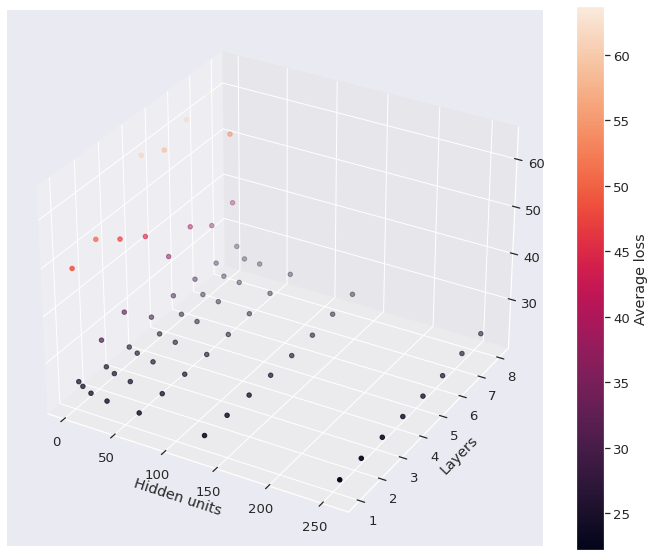

In [19]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='complex_mlp_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='complex_mlp')

##### b) Learning with best parameter

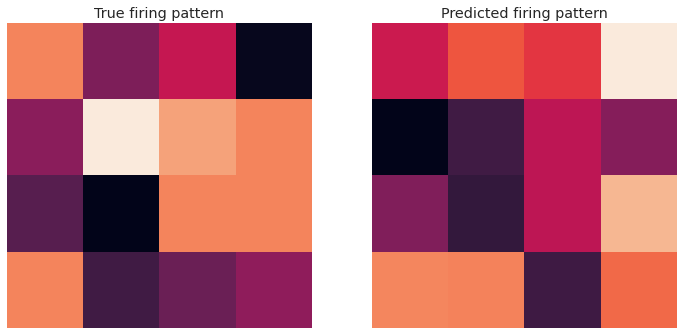

Initial eval loss: 5.020565509796143
Epoch 1: training loss 0.7621408700942993, eval loss 4.977311313152313. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 0.753267765045166, eval loss 4.948650240898132. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 0.7475212216377258, eval loss 4.905807077884674. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 0.7390947341918945, eval loss 4.842704653739929. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 0.7266270518302917, eval loss 4.760871767997742. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 0.7103813290596008, eval loss 4.648819327354431. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 0.6881692409515381, eval loss 4.504216015338898. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 0.6594594120979309, eval loss 4.339868605136871. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 0.6265414953231812, eval loss 4.1775094866752625. Time elapsed: 0 h 0 m 0 s.
Epoch 10: training loss 0.5949381589889526, eval loss 4.373804986476898.

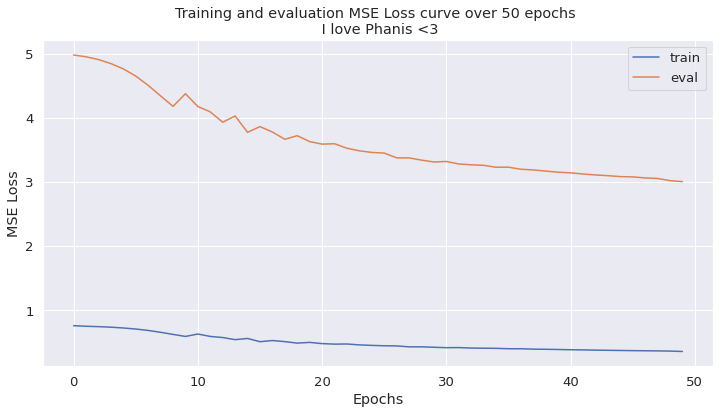

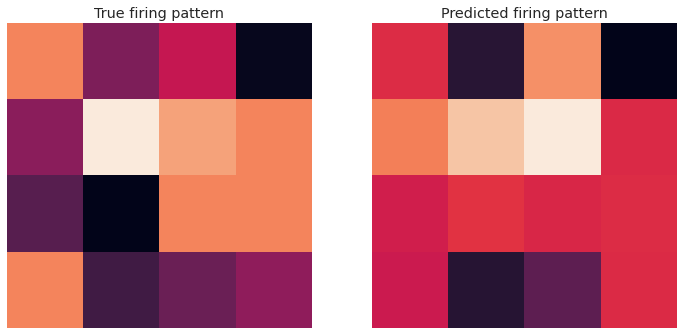

In [4]:
n_layers = 4
hidden_dim = 256

v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=hidden_dim, n_layers=n_layers, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:])) # visualise after training

torch.save(DNN.state_dict(), f'./dnn_params/complex_mlp_{n_layers}_{hidden_dim}.pt')

##### c) Testing against predicting the mean

In [44]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(_X_test), _Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(_Y_test, dim=0).repeat([50000,1]), _Y_test))

DNN prediction MSE error on test set:  tensor(4.4139, device='cuda:0')
Predicting mean MSE error on test set tensor(5.1290, device='cuda:0')


#### 2. Using RNN

##### a) Parameter search

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 2, final eval loss: 22.44295072555542, time elapsed: 0 h 3 m 8 s
2th repeat: best hidden unit: 256, best layers: 7, final eval loss: 22.46644878387451, time elapsed: 0 h 6 m 30 s
3th repeat: best hidden unit: 256, best layers: 5, final eval loss: 22.437827587127686, time elapsed: 0 h 9 m 51 s
4th repeat: best hidden unit: 256, best layers: 4, final eval loss: 22.431431770324707, time elapsed: 0 h 13 m 12 s
5th repeat: best hidden unit: 256, best layers: 4, final eval loss: 22.403598308563232, time elapsed: 0 h 16 m 33 s
6th repeat: best hidden unit: 256, best layers: 4, final eval loss: 22.390442371368408, time elapsed: 0 h 19 m 53 s
7th repeat: best hidden unit: 256, best layers: 4, final eval loss: 22.438467502593994, time elapsed: 0 h 23 m 17 s
8th repeat: best hidden unit: 256, best layers: 7, final eval loss: 22.435606956481934, time elapsed: 0 h 26 m 37 s
9th repeat: best hidden unit:

Best hidden unit: 256, best layers: 4


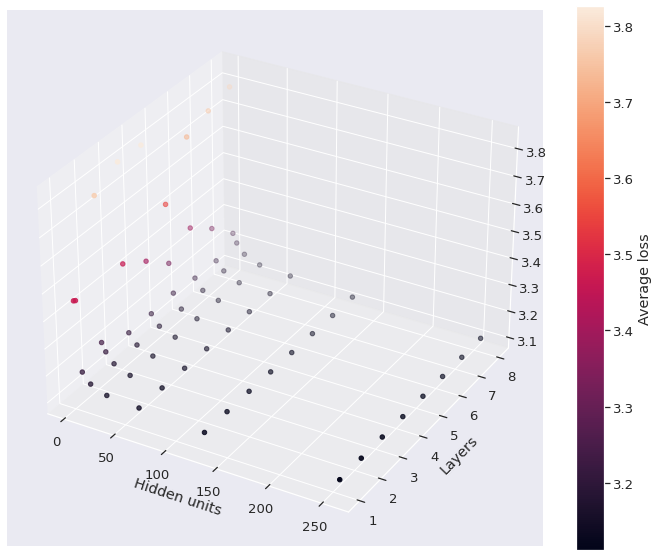

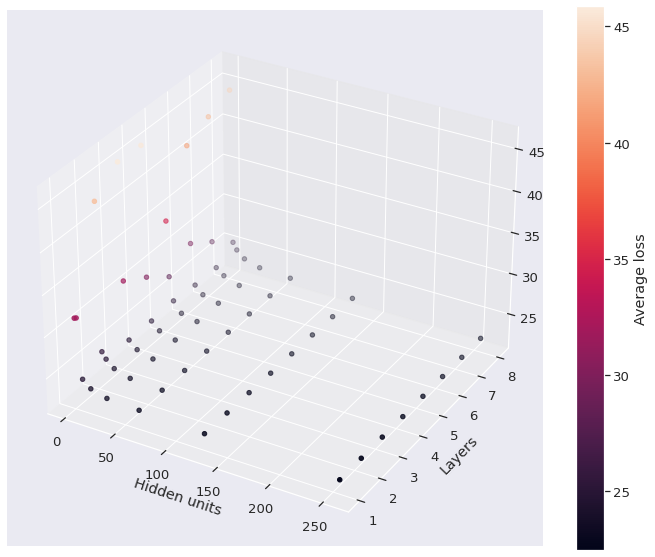

In [4]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='complex_lstm_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='complex_lstm')

##### b) Learning with best parameter

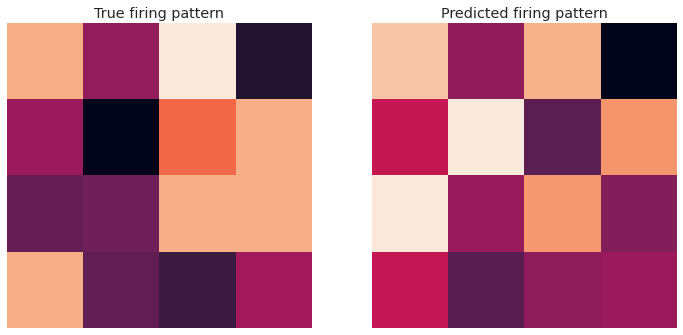

Initial eval loss: 8.813801407814026
Epoch 1: training loss 1.5210446119308472, eval loss 6.913474917411804. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 1.1419868469238281, eval loss 5.993126749992371. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 0.9586624503135681, eval loss 5.651238203048706. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 0.8910704851150513, eval loss 5.605483293533325. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 0.8826367259025574, eval loss 5.650305271148682. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 0.8921113014221191, eval loss 5.675739407539368. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 0.8974649310112, eval loss 5.648523688316345. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 0.8920120000839233, eval loss 5.575458645820618. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 0.8770831823348999, eval loss 5.47429358959198. Time elapsed: 0 h 0 m 0 s.
Epoch 10: training loss 0.8563156127929688, eval loss 5.3561811447143555. Ti

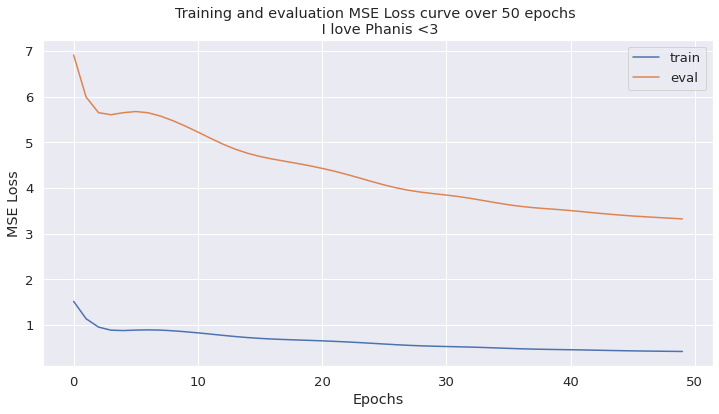

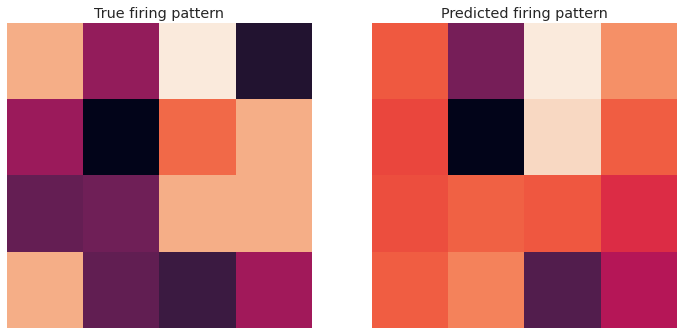

In [15]:
hidden_dim=256
n_linear_layers=8

v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=hidden_dim, n_linear_layers=n_linear_layers, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:])

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=50,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:])

torch.save(DNN.state_dict(), f'./dnn_params/complex_lstm_{n_linear_layers}_{hidden_dim}.pt')

##### c) Testing against predicting the mean

In [16]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

DNN prediction MSE error on test set:  tensor(0.6652, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9990, device='cuda:0')


## Complexity of DNN vs Data Efficiency
What is the least complex DNN that does a good job of mimicking the approximate the complexBNN?

In [17]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

batch_size = 200                            # number of data points in each mini-batch
n_datas = [200, 400, 800, 1600, 3200, 6400, 10000]   # number of train data used, from 1 to len(X_train)
n_epochs = 50                               # number of training epochs

In [18]:
train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [20]:
avg_final_eval_losses = repeated_complexity_varying_data_efficiency(
    hidden_dims=hidden_dims, n_layerss=n_layerss, n_repeats=1, verbose=True,
    **{'input_dim':16,
       'output_dim':16,
       'train_dataset':train_dataset, 
       'test_dataloader':test_dataloader,
       'n_datas':n_datas,
       'n_epochs':n_epochs,
       'batch_size': batch_size})
torch.save(avg_final_eval_losses, './temp/avg_final_eval_loss.pt')

1 of 1 repeats. Time elapsed: time elapsed: 0 h 22 m 37 soints.


Using 200 out of 10000 training data points


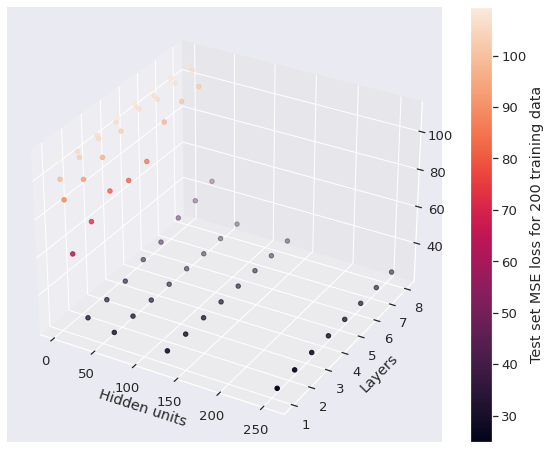

Using 400 out of 10000 training data points


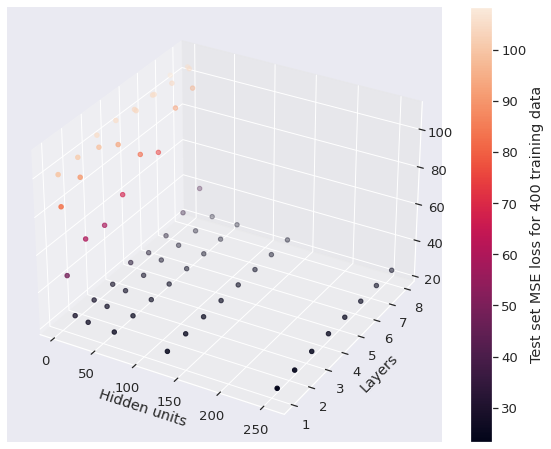

Using 800 out of 10000 training data points


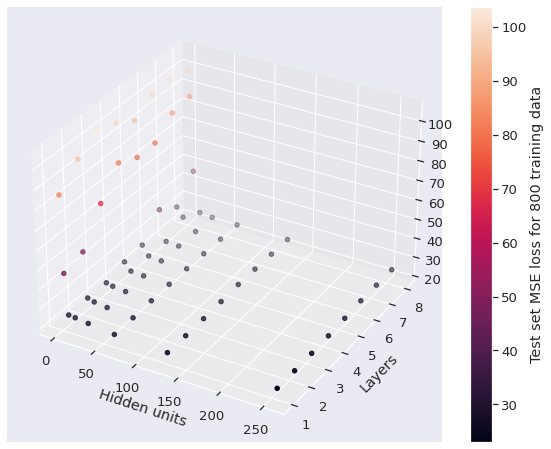

Using 1600 out of 10000 training data points


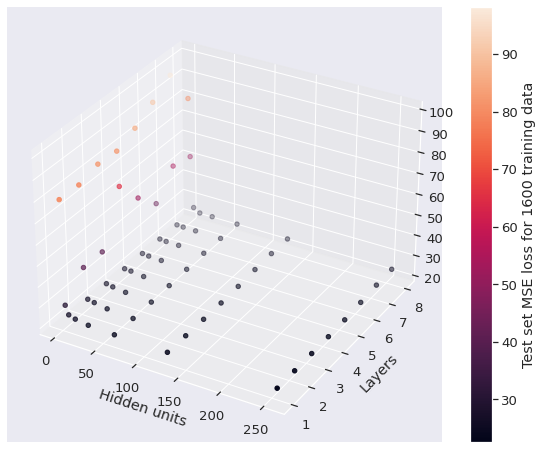

Using 3200 out of 10000 training data points


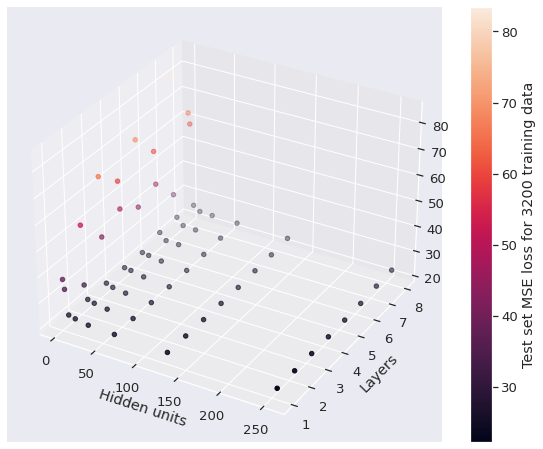

Using 6400 out of 10000 training data points


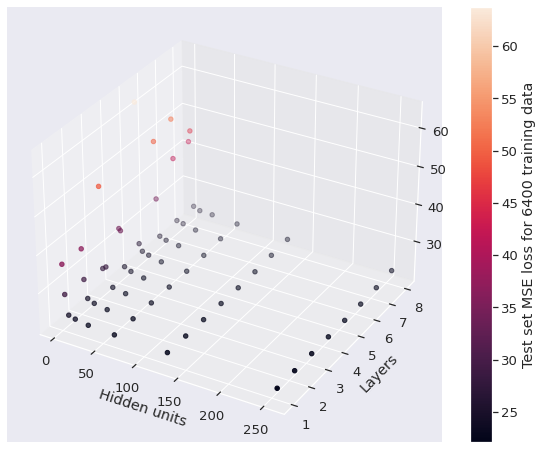

Using 10000 out of 10000 training data points


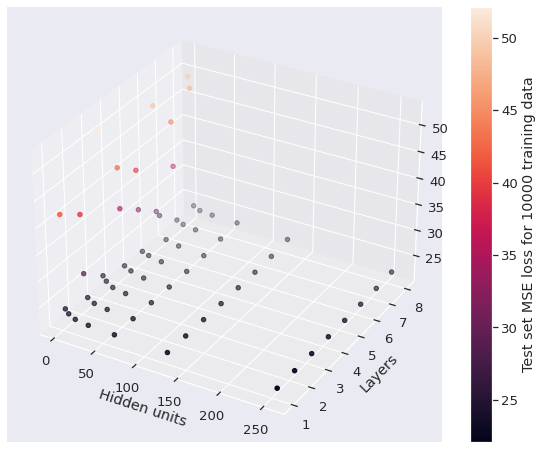

In [14]:
avg_final_eval_losses = torch.load('./temp/avg_final_eval_loss.pt')
for i, n_data in enumerate(n_datas):
    print(f'Using {n_data} out of 10000 training data points')
    plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_losses[:,:,i],
                    x_label='Hidden units', y_label='Layers', z_label= f'Test set MSE loss for {n_data} training data',
                    fname=False, figsize=(10,8))

## BNN Plasticity analysis
We explore to what extent pre-training of a DNN helps when the plasticity of the approximate BNN is changed slightly (according to a Gaussian)

In [4]:
from approx_bnns import ComplexApproximateBNN

# BNN params
x, y, z = 256, 0.5, 4
bias = True
trainable = False
residual_in = [False, False, 1, 2]
num_epochs=25

input_dim = 16
output_dim = 16
batch_size = 200
transfer_functions=[nn.ReLU(), nn.ELU(), nn.SiLU(), nn.CELU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(0.1), nn.LeakyReLU(0.2), nn.LeakyReLU(0.3)]

# initialise BNN, and load original weights
approx_bnn = ComplexApproximateBNN(
    x=x, y=y, z=z, 
    input_dim=input_dim, 
    output_dim=output_dim, 
    residual_in=residual_in, 
    recurrent_dim=-1, 
    transfer_functions=transfer_functions
).to(device)

BNN_weights = torch.load('./approx_bnn_params/complex.pt')
BNN_non_linearities = load_non_linearities('./approx_bnn_params/complex_activations.pkl')
approx_bnn.load_state_dict(BNN_weights)
approx_bnn.load_non_linearities(BNN_non_linearities)

# fixing input pattern
X_train, _ = load_data('./data/', 'train_complex.pkl')
X_test, _ = load_data('./data/', 'test_complex.pkl')
X_valid, _ = load_data('./data/', 'valid_complex.pkl')

### RNN

In [7]:
# initialise DNN
hidden_dim = 256
n_layers = 4
DNN_params = torch.load(f'./dnn_params/complex_lstm_{n_layers}_{hidden_dim}.pt')
DNN = RecurrentDNN(input_dim=16, hidden_dim=hidden_dim, n_linear_layers=n_layers, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

<All keys matched successfully>

In [8]:
sigmas = torch.exp(torch.linspace(-10,0, 25))
params = {'DNN': DNN,
          'BNN': approx_bnn, 
          'DNN_params': DNN_params, 
          'BNN_params': (BNN_weights, BNN_non_linearities), 
          'sigmas': sigmas, 
          'batch_size': batch_size,
          'num_epochs': 10,
          'X_train': X_train, 
          'X_test': X_test,
          'verbose': 0}

In [47]:
mean_transfer, std_transfer = repeated_plasticity_analysis(n_repeats=5, transfer_learning=True, **params)
mean_retrain, std_retrain = repeated_plasticity_analysis(n_repeats=5, transfer_learning=False, **params)

train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

Repeat 1/5
Repeat 2/5
Repeat 3/5
Repeat 4/5
Repeat 5/5
Repeat 1/5
Repeat 2/5
Repeat 3/5
Repeat 4/5
Repeat 5/5


In [10]:
torch.save((mean_transfer, std_transfer), './temp/RNN_plasticity_transfer.pt')
torch.save((mean_retrain, std_retrain), './temp/RNN_plasticity_retrain.pt')

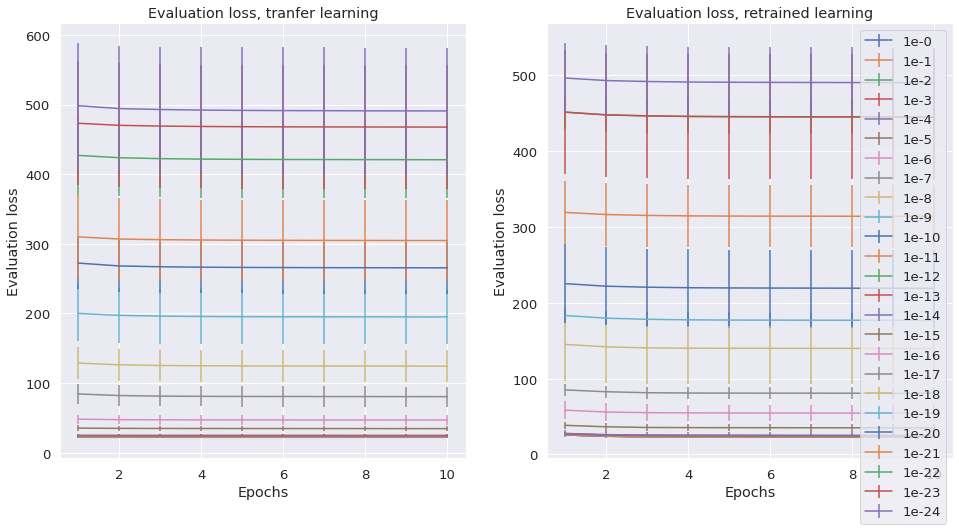

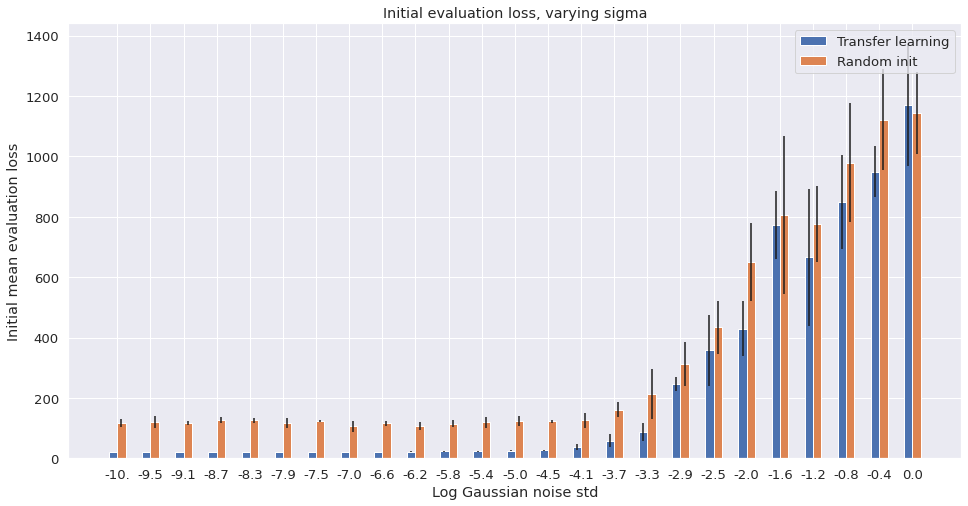

In [48]:
plt.subplots(sharey=True, figsize=(16,8))
plt.subplot(121)
plt.title('Evaluation loss, tranfer learning')
n_sigmas = len(sigmas)
for i in range(mean_transfer[1].shape[0]): # for each sigma
    plt.errorbar(np.arange(1,11), mean_transfer[1][i,:], yerr=std_transfer[1][i,:], label=f'1e-{i}')

plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.subplot(122)
plt.title('Evaluation loss, retrained learning')
for i in range(train_losses_by_sigma_transfer.shape[0]):
    plt.errorbar(np.arange(1,11), mean_retrain[1][i,:], yerr=std_retrain[1][i,:], label=f'1e-{i}')
    
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.legend()

plt.savefig('./figures/plasticity_lstm.png')
plt.show()

width=0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(mean_transfer[2].shape[0]) - width/4, mean_transfer[2], width/2, yerr = std_transfer[2], label='Transfer learning')
ax.bar(np.arange(mean_retrain[2].shape[0]) + width/4, mean_retrain[2], width/2, yerr=std_retrain[2], label='Random init')
plt.legend()
plt.xticks(np.arange(25), [str(i)[:4] for i in np.linspace(-10,0,25)])
plt.xlabel('Log Gaussian noise std')
plt.ylabel('Initial mean evaluation loss')
plt.title('Initial evaluation loss, varying sigma')
plt.savefig('./figures/plasticity_2_lstm.png')
plt.show()

### MLP

In [24]:
# initialise DNN
hidden_dim = 256
n_layers = 3
DNN_params = torch.load(f'./dnn_params/complex_mlp_3_256.pt')
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

mean_transfer, std_transfer = repeated_plasticity_analysis(n_repeats=15, transfer_learning=True, **params)
mean_retrain, std_retrain = repeated_plasticity_analysis(n_repeats=15, transfer_learning=False, **params)

train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

Repeat 1/15
Repeat 2/15
Repeat 3/15
Repeat 4/15
Repeat 5/15
Repeat 6/15
Repeat 7/15
Repeat 8/15
Repeat 9/15
Repeat 10/15
Repeat 11/15
Repeat 12/15
Repeat 13/15
Repeat 14/15
Repeat 15/15
Repeat 1/15
Repeat 2/15
Repeat 3/15
Repeat 4/15
Repeat 5/15
Repeat 6/15
Repeat 7/15
Repeat 8/15
Repeat 9/15
Repeat 10/15
Repeat 11/15
Repeat 12/15
Repeat 13/15
Repeat 14/15
Repeat 15/15


In [3]:
torch.save((mean_transfer, std_transfer), './temp/MLP_plasticity_transfer.pt')
torch.save((mean_retrain, std_retrain), './temp/MLP_plasticity_retrain.pt')

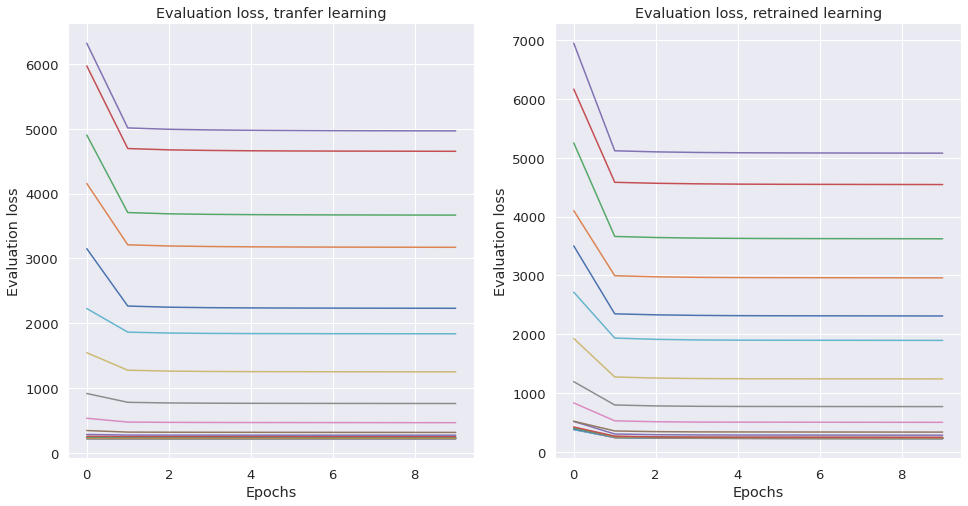

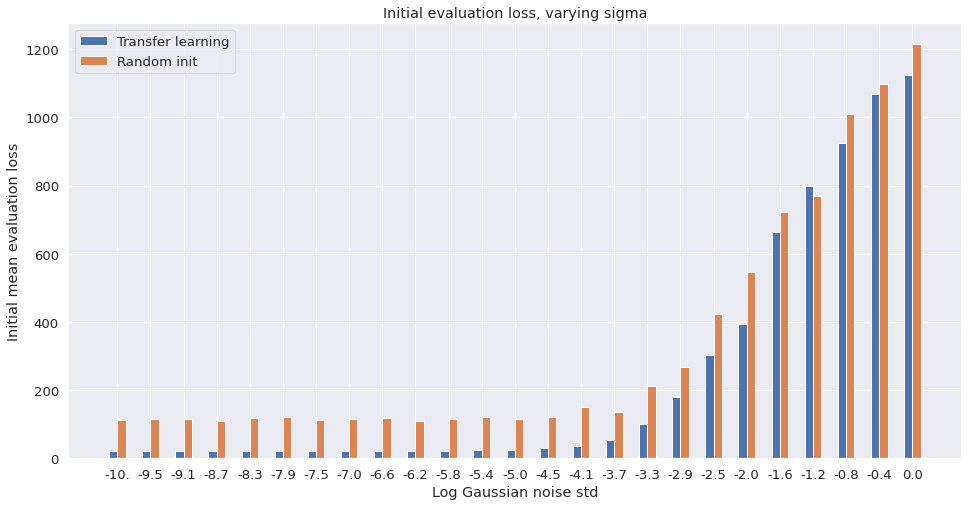

In [25]:
plt.subplots(sharey=True, figsize=(16,8))
plt.subplot(121)
plt.title('Evaluation loss, tranfer learning')
for i in range(train_losses_by_sigma_transfer.shape[0]):
    plt.plot(train_losses_by_sigma_transfer[i,:], label=f'1e-{i}')

plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.subplot(122)
plt.title('Evaluation loss, retrained learning')
for i in range(train_losses_by_sigma_transfer.shape[0]):
    plt.plot(train_losses_by_sigma_reset[i,:], label=f'1e-{i}')
    
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.savefig('./figures/plasticity_mlp.png')
plt.show()

width=0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(init_losses_by_sigma_transfer.shape[0]) - width/4, init_losses_by_sigma_transfer, width/2, label='Transfer learning')
ax.bar(np.arange(init_losses_by_sigma_reset.shape[0]) + width/4, init_losses_by_sigma_reset, width/2, label='Random init')
plt.legend()
plt.xticks(np.arange(25), [str(i)[:4] for i in np.linspace(-10,0,25)])
plt.xlabel('Log Gaussian noise std')
plt.ylabel('Initial mean evaluation loss')
plt.title('Initial evaluation loss, varying sigma')
plt.savefig('./figures/plasticity_2_mlp.png')
plt.show()

SyntaxError: invalid syntax (67005591.py, line 1)